In [7]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from f_Prognosis_relevant_patterns_random_split.overpresented_patterns import calculate_relative_presentation

### Parameters

In [8]:
iteration = 2
PhenoGraph_k = 100
node_label = 'CellType'
size_smallest_cluster  = 10
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 90,
    'knn_k': 30
}
patient_filtering_dict = {
    # 'Clinical Subtype': 'TNBC'
}

### Load Gram matrix and clinical data

#### Discovery

In [9]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_0_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ))

Patient_IDs = SoftWL_dict["Patient_id"]

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical = process_Danenberg_clinical_data(clinical)
Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask


In [16]:
from grakel import Graph
from scipy.linalg import block_diag
FILE_NAMES = os.listdir(
    os.path.join(
        PROJECT_ROOT,
        "Output",
        "b_Soft_WL_Kernel_random_split",
        "Danenberg",
        "Subset_1",
        "Subtrees",
    )
)
G_list = []
Patient_IDs_with_duplicate = []
for i in range(len(FILE_NAMES)):
    file_name = FILE_NAMES[i]
    node_attributes = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "a_Cellular_graph_random_split",
            "Danenberg",
            "Subset_1",
            file_name,
            node_label + ".npy",
        )
    ).tolist()
    A = np.load(
         os.path.join(
            PROJECT_ROOT,
            "Output",
            "a_Cellular_graph_random_split",
            "Danenberg",
            "Subset_1",
            file_name,
            "Adj.npy",
        )
    )
    patient_id = int(file_name.split("_")[1])
    node_attributes = {k: v for k, v in enumerate(node_attributes)}
    G = Graph(A, node_labels=node_attributes)
    G_list.append(G)
    Patient_IDs_with_duplicate.append(patient_id)

print(len(Patient_IDs_with_duplicate), len(np.unique(Patient_IDs_with_duplicate)))
from scipy.linalg import block_diag
G_list_combined = []
for patient_id in Patient_IDs:
    indices = np.where((np.array(Patient_IDs_with_duplicate) == patient_id))[0].tolist()
    A_combined = block_diag(
        *[g.get_adjacency_matrix() for g in np.array(G_list)[indices]]
    )
 
    node_attributes_combined_list = np.concatenate(
        [np.array(list(g.get_labels().values())) for g in np.array(G_list)[indices]]
    ).tolist()
    node_attributes_combined = {
        k: v for k, v in enumerate(node_attributes_combined_list)
    }
    G_combined = Graph(A_combined, node_labels=node_attributes_combined)
    # edge_attributes_combined = {i: 1 for i in G_combined.get_edges()}
    G_combined = Graph(
        A_combined,
        node_labels=node_attributes_combined,
        # edge_labels=edge_attributes_combined,
    )
    G_list_combined.append(G_combined)

Feature = []
for patient_id in Patient_IDs:
    indices = np.where((np.array(Patient_IDs_with_duplicate) == patient_id))[0].tolist()
    A_combined = block_diag(
        *[g.get_adjacency_matrix() for g in np.array(G_list)[indices]]
    )
    node_attributes_combined = np.concatenate(
        [np.array(list(g.get_labels().values())) for g in np.array(G_list)[indices]]
    )
    feature = []
    for i in range(32):
        for j in range(i, 32):
            if np.sum(np.where(node_attributes_combined == i)[0]) == 0 or np.sum(np.where(node_attributes_combined == j)[0]) == 0:
                feature.append(0)
            else:
                feature.append(np.mean(A_combined[
                    np.where(node_attributes_combined == i)[0],
                    :][:, np.where(node_attributes_combined == j)[0]
                ]))
                
    feature = np.array(feature)
    Feature.append(feature)
Feature = np.stack(Feature, axis=0)
print(Feature.shape)

404 379
(379, 528)


In [18]:
from b_Soft_WL_Kernel_random_split.SoftWL import get_Gram_matrix
Gram_matrix = get_Gram_matrix(Feature)
print(Gram_matrix)

[[1.         0.12132849 0.37834014 ... 0.24901694 0.37019617 0.11164999]
 [0.12132849 1.         0.08186226 ... 0.37386324 0.1092802  0.22592344]
 [0.37834014 0.08186226 1.         ... 0.18920994 0.09066049 0.24694557]
 ...
 [0.24901694 0.37386324 0.18920994 ... 1.         0.25492154 0.44622646]
 [0.37019617 0.1092802  0.09066049 ... 0.25492154 1.         0.62090873]
 [0.11164999 0.22592344 0.24694557 ... 0.44622646 0.62090873 1.        ]]


### Community detection

In [19]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)

#### Survival analysis for subgroups

In [20]:
Histograms = Feature
Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs]  
Clinical_subtype = np.array([clinical.loc[clinical['patient_id'] == i,  'Clinical Subtype'].values[0] for i in Patient_IDs])
print(np.unique(Clinical_subtype))
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1


for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

['HR+/HER2+' 'HR+/HER2-' 'HR-/HER2+' 'TNBC' 'nan']
379 patients are included
S1 (N = 63):
Survival: hr = 1.4224035869374003, p = 0.10903086381241867
S2 (N = 45):
Survival: hr = 1.129885087892536, p = 0.6394397757861621
S3 (N = 46):
Survival: hr = 1.004521685860423, p = 0.9869057324472388
S4 (N = 46):
Survival: hr = 0.9012858788272105, p = 0.7137003931141483
S5 (N = 130):
Survival: hr = 0.8986821343618024, p = 0.568241923003371
S6 (N = 49):
Survival: hr = 0.744426761988408, p = 0.3133807349212795


#### Inter-patient similarities

In [21]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
for i in range(1, len(HR)+1):
    Gram_matrix_ = Gram_matrix[Subgroup_ids_ == i, :][:, Subgroup_ids_ == i]
    print("{} subgroup {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], i, caculate_mutual_similarity(Gram_matrix_)))

print("Overall {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))

63 subgroup 1 patients, averaged Intra-group similarity is 0.38 
45 subgroup 2 patients, averaged Intra-group similarity is 0.40 
46 subgroup 3 patients, averaged Intra-group similarity is 0.37 
46 subgroup 4 patients, averaged Intra-group similarity is 0.50 
130 subgroup 5 patients, averaged Intra-group similarity is 0.33 
49 subgroup 6 patients, averaged Intra-group similarity is 0.44 
Overall 379 patients, averaged Intra-group similarity is 0.26 


#### Plot population graph

[[Text(-1.0, 0, ''),
  Text(-0.75, 0, ''),
  Text(-0.5, 0, ''),
  Text(-0.25, 0, ''),
  Text(0.0, 0, ''),
  Text(0.25, 0, ''),
  Text(0.5, 0, ''),
  Text(0.75, 0, ''),
  Text(1.0, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.8, 0, ''),
  Text(-0.6, 0, ''),
  Text(-0.3999999999999999, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.20000000000000018, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.75, 0, ''),
  Text(-0.5, 0, ''),
  Text(-0.25, 0, ''),
  Text(0.0, 0, ''),
  Text(0.25, 0, ''),
  Text(0.5, 0, ''),
  Text(0.75, 0, ''),
  Text(1.0, 0, '')]]

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


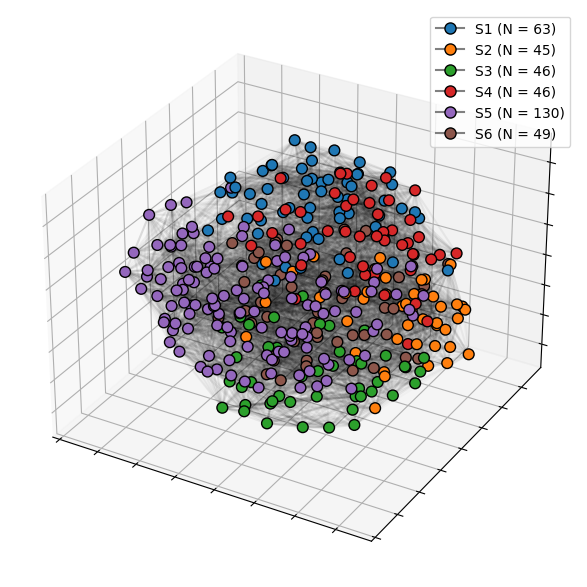

In [22]:
# from mayavi import mlab
G_population = construct_PopulationGraph(
    Gram_matrix,
    "two_step_knn_graph",
    para_dict={"weight_threshold_percentile": 90, "knn_k": 20},
)
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(
    G_population, seed=3, k=1 / (np.sqrt(397)) * 10, iterations=100, dim=3
)
fig = plt.figure(figsize=(6,6), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(G_population)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G_population.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette[int(i)] for i in Subgroup_ids_],
    # c= 'white',
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(G_population.edges())
edge_alpha = [
    0.2*G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0.1 else 0
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color='k')

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)
handles = []
for i in range(1, len(HR)+1):
    handles.append(
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor = color_palette[i],
        label="S{} (N = {})".format(i, np.sum(Subgroup_ids_ == i)),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ))
   
ax.legend(handles=handles, fontsize = 10)

# ax.view_init(30, 0)
# ax.set_axis_off()
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])
# ax.set(xlabel="x", ylabel="y", zlabel="z")


#### Plot hazard ratio

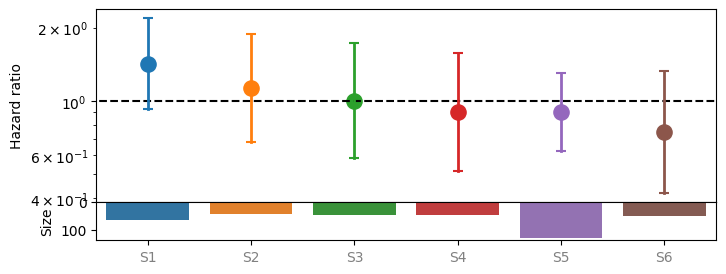

In [23]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

#### Plot K-M Plot

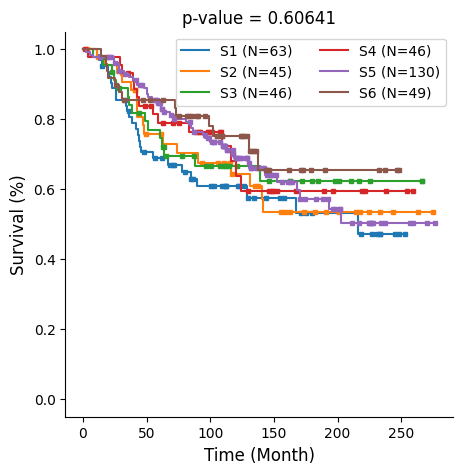

In [24]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()